In [84]:
import pandas as pd
from collections import Counter
import numpy as np 
import string
import re
from sklearn.model_selection import train_test_split
from __future__ import print_function
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from xgboost import XGBClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
import collections
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import nltk
import nltk.data
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pickle

In [2]:
total = pd.read_csv('./dataset/preprocessed_dataset.csv',sep=",")

In [3]:
total.head()

,body,tags
0,write daemon run emb platform need chang defau...,"c,linux,networking"
1,use gdi+ c++ two problem find canvasimg black ...,"canvas,gdi+"
2,write program need determin bit set know rotat...,"assembly,bit-manipulation,mips"
3,consol applic server accept sever connect clie...,"java,events,listener"
4,attempt provid script solut read content file ...,"javascript,html,file-io,sandbox"


In [12]:
def setupMLBTagList(df):        
    mlb_tags_lists = []    
    for tags in df['tags']:
        #print(tags)
        inner_list = []
        if type(tags) == float:
            tags = ''
        for tag in tags.split(','):
            inner_list.append(tag)
        mlb_tags_lists.append(inner_list)
    
    return mlb_tags_lists

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_list = setupMLBTagList(total)
tags_list[0]
mlb.fit(tags_list)
mlb.classes_

array(['', '.emf', '.htaccess', ..., 'zsh', 'zsh-completion', 'zshrc'],
      dtype=object)

[('c#', 70), ('asp.net-mvc', 53), ('python', 40), ('iphone', 34), ('asp.net', 32), ('javascript,jquery', 31), ('jquery', 29), ('javascript', 29), ('c#,.net', 28), ('php', 26), ('sql-server', 23), ('java', 23), ('c++', 19), ('c#,asp.net', 18), ('ruby-on-rails', 18), ('iphone,cocoa-touch', 17), ('mysql', 17), ('html,css', 16), ('vb.net', 16), ('sql', 15)]


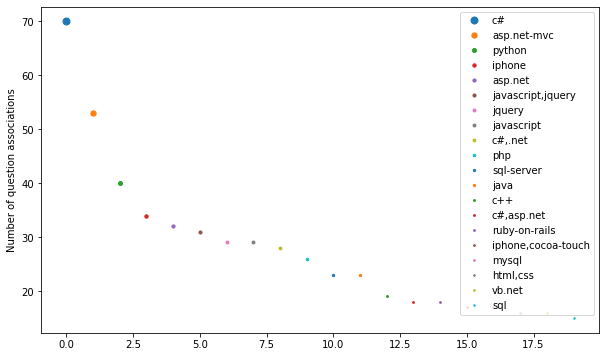

In [4]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]
    area = [i/10 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10,6))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
      plt.plot(i,y[i],marker='o',linestyle='',ms=area[i],label=x[i])   
    plt.legend(numpoints=1)
    plt.show()

tagCount =  collections.Counter(list(total['tags'])).most_common(20)
print(tagCount)
plot_tags(tagCount)

In [5]:
total = total[
        (total.tags == 'c#') | (total.tags == 'asp.net-mvc') | (total.tags == 'python') | (total.tags =='iphone') | 
        (total.tags =='asp.net') | (total.tags == 'javascript,jquery') | (total.tags == 'javascript') | (total.tags == 'c#,.net') | 
        (total.tags == 'php') | (total.tags == 'sql-server') |
        (total.tags == 'java') | (total.tags == 'c++') | (total.tags == 'c#,asp.net') | (total.tags =='ruby-on-rails') | 
        (total.tags == 'iphone,cocoa-touch') | (total.tags == 'mysql') | (total.tags == 'html,css') | (total.tags =='vb.net') | (total.tags =='sql')
        ]

In [6]:
def tokenize(text):
    result = ""
    #print(type(text))
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
             result = result + ' ' + token
    return result

processed_body = total['body'].map(tokenize)

In [28]:
vectorizer = TfidfVectorizer(max_features=10000, use_idf=True)
vectorizer = vectorizer.fit(total['body'])
tf_len = len(vectorizer.vocabulary_)
X = vectorizer.transform(processed_body).astype('float64')
y = total['tags']

In [62]:
type(X)

scipy.sparse.csr.csr_matrix

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

In [9]:
target_names=total['tags'].unique()
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))


    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                        target_names=target_names))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    clf_descr = str(clf).split('(')[0]

    return clf_descr, score, train_time, test_time



Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(tol=0.01)
train time: 0.326s
test time:  0.001s
accuracy:   0.362
dimensionality: 2878
density: 0.830090
classification report:
                    precision    recall  f1-score   support

          html,css       0.20      0.14      0.17         7
                c#       0.50      0.86      0.63         7
           c#,.net       0.18      0.46      0.26        13
            python       0.00      0.00      0.00         7
        sql-server       0.00      0.00      0.00         3
 javascript,jquery       0.00      0.00      0.00         4
               php       1.00      1.00      1.00         3
            iphone       0.33      0.20      0.25         5
           asp.net       0.33      0.25      0.29         4
               c++       0.50      0.33      0.40         6
       asp.net-mvc       1.00      0.33      0.50         9
            vb.net       0

/home/alpro/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alpro/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alpro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting 

train time: 0.050s
test time:  0.001s
accuracy:   0.305
classification report:
                    precision    recall  f1-score   support

          html,css       0.00      0.00      0.00         7
                c#       0.46      0.86      0.60         7
           c#,.net       0.10      0.23      0.14        13
            python       0.17      0.14      0.15         7
        sql-server       0.00      0.00      0.00         3
 javascript,jquery       0.00      0.00      0.00         4
               php       0.67      0.67      0.67         3
            iphone       0.50      0.40      0.44         5
           asp.net       0.50      0.50      0.50         4
               c++       0.40      0.33      0.36         6
       asp.net-mvc       0.33      0.11      0.17         9
            vb.net       0.25      0.17      0.20         6
        c#,asp.net       0.25      0.50      0.33         2
              java       1.00      0.43      0.60         7
iphone,cocoa-touch  

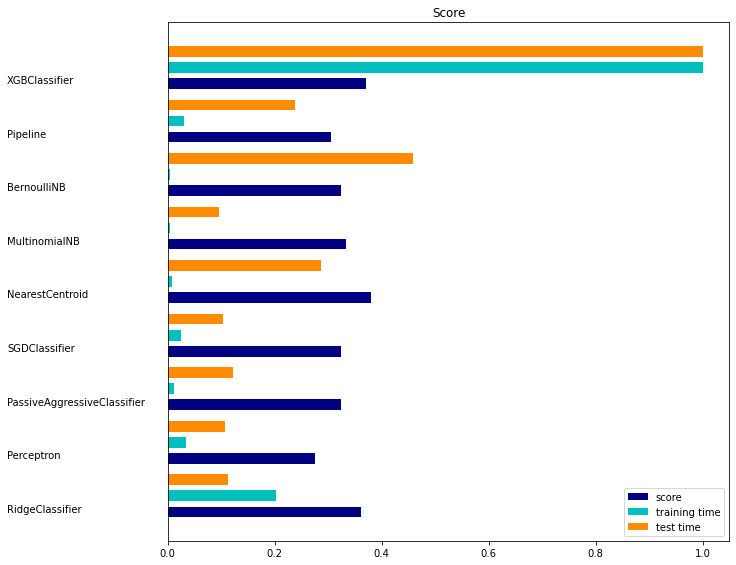

In [10]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        (Perceptron(tol=1e-3, random_state=0), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=100, random_state=0, tol=1e-3), "Passive-Aggressive")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(max_iter=1000, tol=1e-3,
                                       penalty="elasticnet")))

print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

print('=' * 80)
print("XGBoost")
results.append(benchmark(XGBClassifier()))


indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]
clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
plt.show()

### Mise au point du modèle retenu

On retient le XGBoost

In [35]:
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 20,
    'n_gpus': 0
}
pipe_xgb = Pipeline([
    ('clf', XGBClassifier(**params))
    ])

parameters_xgb = {
        'clf__n_estimators':[30,40], 
        'clf__criterion':['entropy'], 
        'clf__min_samples_split':[15,20], 
        'clf__min_samples_leaf':[3,4]
    }

grid_xgb = GridSearchCV(pipe_xgb,
    param_grid=parameters_xgb,
    scoring='accuracy',
    cv=5,
    refit=True)

In [36]:
grid_xgb.fit(X_train, y_train)

/home/alpro/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:05] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:06:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:06:06] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:06:06] WARN

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=6,
                                                      min_child_weight=None,
                             

In [39]:
acc = grid_xgb.score(X_test,y_test)
print("Best params                        : %s" % grid_xgb.best_params_)
print("Best training data accuracy        : %s" % grid_xgb.best_score_)    
print("Best validation data accuracy (*)  : %s" % acc)

Best params                        : {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 15, 'clf__n_estimators': 30}
Best training data accuracy        : 0.4714285714285714
Best validation data accuracy (*)  : 0.3904761904761905


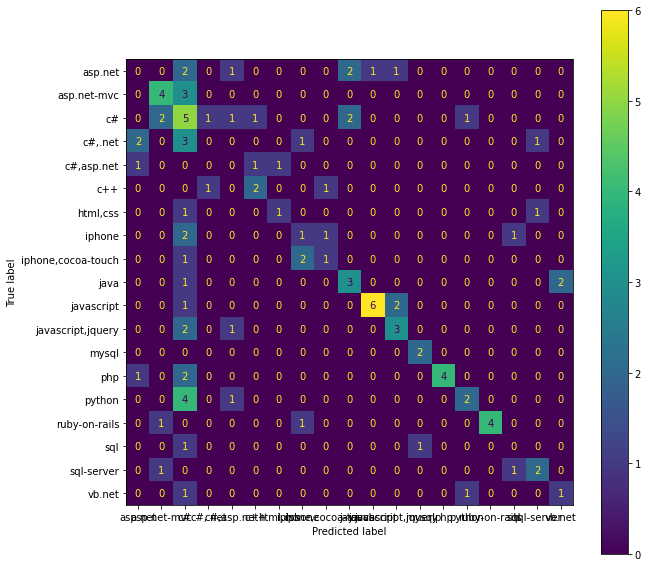

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_xgb, X_test, y_test, ax=ax)
plt.show() 

In [60]:
#Prediction sur la base du dataset de test
y_pred = grid_xgb.predict(X_test)
accuracy_score(y_test, y_pred)

<class 'scipy.sparse.csr.csr_matrix'>


0.3904761904761905

### Prediction sur un exemple

In [69]:
post = "Hello, I am developing a new application and I need to create a new table in sql-server database. " \
    "My application is an HTML form and I submit it through a javascript function. How can I do that ? Thanks !"

In [70]:
def myTokenizer(text):
    '''
    Create tokens from text (English words > 3 letters)
    '''
    def stem_tokens(tokens, stemmer):
        '''
        Stem words in tokens.
        and suppress word < 3 characters
        '''
        stemmed = []
        for item in tokens:
            if re.match('[a-zA-Z0-9]{3,}',item):
                stemmed.append(stemmer.stem(item))
        return stemmed

    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, EnglishStemmer())
    return stems

In [78]:
def predict(post, vectorizer, model):
    pattern = re.compile('[^A-Za-z +]')
    intermediate = re.sub(pattern, ' ', post)
    intermediate = post.lower()

    stop_words = set(stopwords.words('english')) 
    #print(text)
    word_tokens = word_tokenize(intermediate) 
    filtered_text = ' '.join(w for w in word_tokens if not w in stop_words)

    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = EnglishStemmer()
    stemmed = myTokenizer(filtered_text)
    x_input = vectorizer.transform(stemmed).astype('float64')
    tags = model.predict(x_input)
    return tags

In [80]:
tags = predict(post,vectorizer,grid_xgb)
tags

array(['c#', 'c#', 'c#', 'c#', 'c#', 'c#', 'c#', 'sql', 'sql-server',
       'c#', 'c#', 'c#', 'vb.net', 'c#', 'c#', 'c#', 'c#'], dtype=object)

### Save model

In [81]:
pickle.dump(grid_xgb, open('./../models/xgb.obj', 'wb'))

NameError: name 'pickle' is not defined

In [ ]:
pickle.dump(vectorizer, open('./../models/vectorizer.obj', 'wb'))